In [ ]:
#pip install pyod
#pip install sklearn
#pip install tensorflow

In [47]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from combo.models.score_comb import aom, moa

#models
from pyod.models.pca import PCA
from pyod.models.copod import COPOD
from pyod.models.hbos import HBOS
from pyod.models.loda import LODA
from pyod.models.iforest import IForest
#from pyod.models.mcd import MCD
from pyod.models.cblof import CBLOF

from pyod.models.lof import LOF
#from pyod.models.knn import KNN
#from pyod.models.sod import SOD
#from pyod.models.sos import SOS
#from pyod.models.feature_bagging import FeatureBagging
#from pyod.models.abod import ABOD
#from pyod.models.ocsvm import OCSVM
#from pyod.models.lscp import LSCP
#from pyod.models.cof import COF

from pyod.models.vae import VAE

import pandas as pd
import numpy as np
from scipy.stats import rankdata

import traceback

##########
import time
from datetime import datetime
import pytz
class log:
    def_tz = pytz.timezone('Pacific/Auckland')
    def info(text):        
        print(f'{datetime.now(log.def_tz).replace(microsecond=0)} : {text}');
#############

def rank_fun(arr):
    return rankdata(arr, method = 'dense')

class Anomaly:
    def_dict = '. !?:,\'%-()\/$|&;[]{}"0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    def_unknown = 'UN'
    
    def __init__(self, max_len_col = None, max_num_col = None):
                
        self.max_len_col = max_len_col
        self.max_num_col = max_num_col
        self.unknown_char = ''
        self.char_ind = None
        self.ind_char = None
        
    def create_dict(self, char_dict = None, unknown_char = None):
        char_dict = char_dict or self.def_dict
        unknown_char = unknown_char or self.def_unknown
        char_list = list(set(char_dict)) #set() additionally randomizes char order
        #char_list = sorted(char_list) #sorted alphabetically
        char_list.insert(0, unknown_char)
        #char_list.insert(len(char_list)//2, unknown_char)        
        
        self.unknown_char = unknown_char
        self.char_ind = dict((c, i) for i, c in enumerate(char_list))
        self.ind_char = dict((i, c) for i, c in enumerate(char_list))
    
    def calc_max_len(self, df, col_len = 'max'):
        measurer = np.vectorize(len)
        #cols_length = measurer(df.select_dtypes(include=[object]).values.astype(str)).max(axis=0)
        cols_length = np.quantile(measurer(df.select_dtypes(include=[object]).values.astype(str)), 0.95, axis=0)
        if col_len == 'mean':
            max_len = int(cols_length.mean())
        elif col_len == 'max':
            max_len = int(max(cols_length))
        elif col_len == 'min':
            max_len = int(min(cols_length))
        else:
            raise ValueError("Only mean/max/min for max_col_len is available") 
       
        self.max_len_num = max_len
        
        return max_len
        
    def text_process(self, df, max_len_col = None, max_num_col = None, 
                  to_lower = False, mirror_out = False, col_len = 'max',
                  char_dict = None, unknown_char = None):
        
        self.max_len_col = max_len_col or self.max_len_col or self.calc_max_len(df, col_len)
        self.max_num_col = max_num_col or self.max_num_col or df.shape[1]
        
        log.info(f'num_col={self.max_num_col}, len_col={self.max_len_col}')
        
        self.create_dict(char_dict, unknown_char)
        
        unk_index = self.char_ind[self.unknown_char]
        
        x_raw = df.to_numpy()
        
        x = np.ones((len(x_raw), self.max_num_col, self.max_len_col), dtype=np.int64) * unk_index
        y = np.zeros((len(x_raw), self.max_num_col, self.max_len_col), dtype=np.object)
 
        for i, doc in enumerate(x_raw):
            for j, sentence in enumerate(doc):
                if sentence is not np.nan and j < self.max_num_col:
                    try:
                        trunc_sentence = sentence[0:self.max_len_col]
                        if to_lower:
                            trunc_sentence = trunc_sentence.lower()
                            
                        for t, char in enumerate(trunc_sentence):
                            #log.info(f'i = {i}, j = {j}, t = {t}, char = {char}')
                            if mirror_out:
                                l = self.max_len_col - t - 1
                            else:
                                l = t - self.max_len_col
                            
                            if char not in self.char_ind:
                                x[i, j, l] = unk_index
                                y[i, j, l] = "UNC"
                            else:
                                x[i, j, l] = self.char_ind[char]
                                y[i, j, l] = char
                    except:
                        log.info(f'i={i}, j={j}, t={t}, sentence = {sentence}')
                        log.info(traceback.print_exc())
        return x, y
    def full_autoencoder(self, X, neurons_list = [64, 32, 32, 64], 
                     hidden_activation = 'relu', output_activation = 'sigmoid', 
                     activity_regularizer = keras.regularizers.l2(), dropout_rate = 0.20,
                     optimizer = keras.optimizers.Adam(), loss = keras.losses.mean_squared_error,
                     batch_size = 32, epochs = 100, patience = 5, validation_split = 0.1, verbose = 1):
        model = Sequential()
        # Input layer
        model.add(Dense(
            X.shape[1], activation = hidden_activation,
            input_shape=(X.shape[1],),
            activity_regularizer=activity_regularizer))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i, hidden_neurons in enumerate(neurons_list, 1):
            model.add(Dense(
                hidden_neurons,
                activation=hidden_activation,
                activity_regularizer=activity_regularizer))
            model.add(Dropout(dropout_rate))

        # Output layers
        model.add(Dense(X.shape[1], activation=output_activation,
                        activity_regularizer=activity_regularizer))


        model.compile(loss = loss, optimizer = optimizer)
        if verbose >= 1:
            log.info(model.summary())    
        
        #Early Stopping
        my_callbacks = [EarlyStopping(patience=patience)]
    
        #Additional shuffling
        X_shuffle = np.copy(X)
        np.random.shuffle(X_shuffle)
        
        #Fit on shuffled
        model.fit(X_shuffle, X_shuffle, epochs = epochs, batch_size = batch_size, 
                  shuffle=True, validation_split = validation_split,
                  callbacks=my_callbacks, verbose = verbose)
        
        #Predict on original
        pred = model.predict(X)
        
        return np.sqrt(np.sum(np.square(pred - X), axis=1)).ravel()    
    
    def fit(self, X, shrink_cols = True, data_scaler = preprocessing.MaxAbsScaler(), 
            quick_methods = True, slow_methods = False, nn_methods = False, 
            contamination = 0.05, use_score_rank = False, random_state = None, verbose = 0):

        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        elif len(X.shape) > 3:
            raise ValueError("Expected number of dimensions: 2 or 3") 
        
        if shrink_cols:
            X = X[:,~np.all(X == 0, axis=0)]
            log.info('zero columns shrinked')
        if data_scaler:
            X = data_scaler.fit_transform(X)
            log.info(f'used {data_scaler} data scaler')
            #log.info(X[0:1,:])
        
        n_rows = X.shape[0]
        n_features = X.shape[1]
        log.info (f'n_rows = {n_rows}, n_features = {n_features}')
        
        quick_scores = np.zeros([n_rows, 0])
        slow_scores = np.zeros([n_rows, 0])
        nn_scores = np.zeros([n_rows, 0])
        
        if quick_methods:
            # Define anomaly detection tools to be compared
            quick_classifiers = {
                'PCA_randomized':
                    PCA(contamination=contamination, random_state=random_state, 
                        standardization = False, svd_solver = 'randomized'),
                'PCA_full':
                    PCA(contamination=contamination, random_state=random_state, 
                        standardization = False, svd_solver = 'full'),                               
                'COPOD':
                   COPOD(contamination=contamination),  
                f'HBOS': 
                    HBOS(contamination=contamination),
                f'HBOS_{200}': 
                    HBOS(contamination=contamination, n_bins = 200),                
                f'HBOS_{300}':  
                    HBOS(contamination=contamination, n_bins = 300), 
                'LODA':
                    LODA(contamination=contamination),
                'LODA_200':
                    LODA(contamination=contamination, n_random_cuts  = 200),
                'LODA_300':
                    LODA(contamination=contamination, n_random_cuts  = 300),                
                'IForest_100':
                    IForest(contamination=contamination, random_state=random_state, 
                            n_estimators = 100, bootstrap = False, n_jobs = -1),
                'IForest_200':
                    IForest(contamination=contamination, random_state=random_state, 
                            n_estimators = 200, bootstrap = False, n_jobs = -1),                
                'IForest_bootstrap':
                    IForest(contamination = contamination, random_state=random_state, 
                            n_estimators = 150, bootstrap = True, n_jobs = -1), 
                #'MCD': 
                #    MCD(contamination=contamination, random_state=random_state, assume_centered = False),
                #'MCD_centered': 
                #    MCD(contamination=contamination, random_state=random_state, assume_centered = True),    
                f'CBLOF_16':
                    CBLOF(contamination=contamination, random_state=random_state, n_clusters = 16),
                f'CBLOF_24':
                    CBLOF(contamination=contamination, random_state=random_state, n_clusters = 24),
                f'CBLOF_32':
                    CBLOF(contamination=contamination, random_state=random_state, n_clusters = 32)
            }
            
            quick_scores = np.zeros([n_rows, len(quick_classifiers)])

            for i, (clf_name, clf) in enumerate(quick_classifiers.items()):
                log.info(f'{i+1} - fitting {clf_name}')
                try:
                    clf.fit(X)
                    quick_scores[:, i] = clf.decision_scores_
                except:
                    log.info(traceback.print_exc())
                else:    
                    log.info(f'Base detector {i+1}/{len(quick_classifiers)} is fitted for prediction') 

            quick_scores = np.nan_to_num(quick_scores)
            
        if slow_methods:
            # initialize a set of detectors for LSCP
            detector_list = [LOF(n_neighbors=10), LOF(n_neighbors=15), LOF(n_neighbors=20)]
            slow_classifiers = {               
                #'Angle-based Outlier Detector (ABOD)': #too slow and nan results
                #   ABOD(contamination=contamination),
                #'One-class SVM (OCSVM)':
                #   OCSVM(contamination=contamination, cache_size = 2000, shrinking = False, tol = 1e-2),   
                #'LSCP': #slow and no parallel
                #   LSCP(detector_list, contamination=contamination, random_state=random_state, local_region_size = 30),
                #'Feature Bagging': #ensemble #no real par
                #   FeatureBagging(LOF(n_neighbors=20), contamination=contamination, 
                #                  random_state=random_state, n_jobs = -1),                
                #'SOS' : # too memory inefficient  
                #    SOS(contamination=contamination),
                #'COF': # memory inefficient
                #   COF(contamination=contamination),                  
                #'SOD':
                #    SOD(contamination = contamination),
                #'KNN': 
                #   KNN(contamination=contamination, n_jobs = -1),
                #'KNN_50': 
                #   KNN(contamination=contamination, leaf_size = 50, n_jobs = -1),
                #'KNN_70': 
                #   KNN(contamination=contamination, leaf_size = 70, n_jobs = -1),

                'LOF_4':
                   LOF(n_neighbors=4, contamination=contamination, n_jobs = -1),
                'LOF_5':
                   LOF(n_neighbors=5, contamination=contamination, n_jobs = -1),                
                'LOF_6':
                   LOF(n_neighbors=6, contamination=contamination, n_jobs = -1),
                'LOF_7':
                   LOF(n_neighbors=7, contamination=contamination, n_jobs = -1),                
                'LOF_8':
                   LOF(n_neighbors=8, contamination=contamination, n_jobs = -1),
                'LOF_9':
                   LOF(n_neighbors=9, contamination=contamination, n_jobs = -1),                
                'LOF_10':
                   LOF(n_neighbors=10, contamination=contamination, n_jobs = -1),
                'LOF_12':
                   LOF(n_neighbors=12, contamination=contamination, n_jobs = -1),  
                'LOF_14':
                   LOF(n_neighbors=14, contamination=contamination, n_jobs = -1),
                'LOF_16':
                   LOF(n_neighbors=16, contamination=contamination, n_jobs = -1),
                'LOF_18':
                   LOF(n_neighbors=18, contamination=contamination, n_jobs = -1),
                'LOF_20':
                   LOF(n_neighbors=20, contamination=contamination, n_jobs = -1), 
                'LOF_22':
                   LOF(n_neighbors=22, contamination=contamination, n_jobs = -1)            
            }
            
            slow_scores = np.zeros([n_rows, len(slow_classifiers)])

            for i, (clf_name, clf) in enumerate(slow_classifiers.items()):
                log.info(f'{i+1} - fitting {clf_name}')
                try:
                    clf.fit(X)
                    slow_scores[:, i] = clf.decision_scores_
                except:
                    log.info(traceback.print_exc())
                else:    
                    log.info(f'Base detector {i+1}/{len(slow_classifiers)} is fitted for prediction') 
            
            slow_scores = np.nan_to_num(slow_scores)
        
        if nn_methods:
            
            nn_classifiers = {}
            n_list = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
            n_idx = next(x[0] for x in enumerate(n_list) if x[1] < n_features)
            for i in range(3,6):
                n_enc = n_list[n_idx:n_idx+i-1] 
                n_dec = n_enc[::-1]
                n_enc_dec = n_enc + n_dec
                nn_classifiers[f'FULL_AE_{len(n_enc + n_dec)}'] = {'clf': self.full_autoencoder, 
                                                                   'hidden_layers' : n_enc_dec
                                                                  }
                nn_classifiers[f'VAE_{len(n_enc_dec)}'] = {'clf': VAE(contamination = contamination, random_state = random_state,
                                                                      encoder_neurons  = n_enc, decoder_neurons = n_dec,
                                                                      preprocessing = False, epochs = 32, verbosity = verbose), 
                                                            'hidden_layers' : n_enc + n_dec
                                                            }                
                
            
            nn_scores = np.zeros([n_rows, len(nn_classifiers)])
            
            for i, (clf_name, clf) in enumerate(nn_classifiers.items()):
                log.info(f'''{i+1} - fitting {clf_name} with layers {clf['hidden_layers']}''')
                try:
                    if clf['clf'] == self.full_autoencoder:
                        nn_scores[:, i] = clf['clf'](X, neurons_list = clf['hidden_layers'], verbose = verbose)
                    else:
                        clf['clf'].fit(X)
                        nn_scores[:, i] = clf['clf'].decision_scores_                        
                except:
                    log.info(traceback.print_exc())
                else:    
                    log.info(f'Base detector {i+1}/{len(nn_classifiers)} is fitted for prediction')             

            nn_scores = np.nan_to_num(nn_scores)

            
        all_scores = np.concatenate((quick_scores, slow_scores, nn_scores), axis=1)
        all_scores = all_scores[:,~np.all(all_scores == 0, axis=0)]
        log.info(f'total scores = {all_scores.shape[1]}')
        
        all_scores_norm = np.copy(all_scores)
        if use_score_rank:
            all_scores_norm = np.apply_along_axis(rank_fun, 0, all_scores_norm)
            log.info(f'score rank applied')
        all_scores_norm = preprocessing.MinMaxScaler().fit_transform(all_scores_norm)
        
        if all_scores_norm.shape[1] >= 12:
            score_by_aom = aom(all_scores_norm, method = 'dynamic', n_buckets = round(all_scores_norm.shape[1]/4))
            score_by_moa = moa(all_scores_norm, method = 'dynamic', n_buckets = round(all_scores_norm.shape[1]/4))
            score_by_avg = np.mean(all_scores_norm, axis = 1) 
            score_by_max = np.max(all_scores_norm, axis = 1)
        else:
            score_by_avg = np.mean(all_scores_norm, axis = 1)
            score_by_max = np.max(all_scores_norm, axis = 1)
            score_by_aom = score_by_avg
            score_by_moa = score_by_max
        return score_by_aom, score_by_moa, score_by_max, score_by_avg, all_scores, all_scores_norm


In [48]:
def get_data(f_name):
    
    if f_name == 'Deloitte_KX_OpenData_Contact List_03 Aug 2020.csv':
        df_raw = pd.read_csv(f_name, keep_default_na = False, na_values = 'NaN')
        x_cols = ['First Name', 'Last Name', 'Address Line 1']
        
        ##Test injection
        df_test = pd.DataFrame([['John', 'Carter', '1 Queen Street'], 
                     ['Johhnn', 'Carteerr', '1111111 Sort Of Wrong Address']], columns=x_cols)
        df_raw = pd.concat([df_raw, df_test])
        ##end of test injection
    
    elif f_name == 'aloi-unsupervised-ad.csv':
        #Harvard Dataverse>Unsupervised Anomaly Detection Dataverse>Unsupervised Anomaly Detection Benchmark>
        # aloi-unsupervised-ad.tab
        #https://doi.org/10.7910/DVN/OPQMVF/7VDJBV, Harvard Dataverse, V1, UNF:6:IkCoNEXH+d/YfqLkZQ0NVw== [fileUNF]

        df_raw = pd.read_csv(f_name, header = None)
        df_raw.rename({df_raw.columns[-1] : 'label'}, axis = 'columns', inplace = True)  
        df_raw.loc[df_raw.label == 'o', 'label'] = 1
        df_raw.loc[df_raw.label == 'n', 'label'] = 0

        df_raw['label'] = df_raw['label'].astype(bool)

        x_cols = df_raw.columns[0:-1]    

    elif f_name == 'SMSSpamCollection':
        import csv
        #http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
        df_raw = pd.read_csv(f_name, sep = '\t', quoting=csv.QUOTE_NONE, header = None)
        df_raw.rename({df_raw.columns[0] : 'label'}, axis = 'columns', inplace = True)  
        df_raw.loc[df_raw.label == 'spam', 'label'] = 1
        df_raw.loc[df_raw.label == 'ham', 'label'] = 0

        df_raw['label'] = df_raw['label'].astype(bool)

        x_cols = df_raw.columns[1:]
    
    elif f_name == 'generate data':
        #generated data
        from pyod.utils.data import generate_data
        X_train, _, y_train, _ = generate_data(n_train=10000,
                                               n_test=0,
                                               n_features=20,
                                               contamination=0.02,
                                               behaviour ='new',
                                               random_state=84)
        df_raw = pd.DataFrame(X_train)
        df_raw['label'] = y_train.astype(bool)
        x_cols = df_raw.columns[0:-1]
        
    elif f_name == 'generate clusters':
        #generated clusters
        from pyod.utils.data import  generate_data_clusters
        X_train, _, y_train, _ =  generate_data_clusters(n_train=10000,
                                                         n_clusters=15,
                                                         n_test=10,
                                                         n_features=20,
                                                         size ='different',
                                                         density = 'different',
                                                         return_in_clusters =False,
                                                         contamination=0.01,
                                                         random_state=126)
        df_raw = pd.DataFrame(X_train)
        df_raw['label'] = y_train.astype(bool)
        x_cols = df_raw.columns[0:-1]
        
    return df_raw, x_cols

In [49]:
#df_raw, x_cols = get_data('Deloitte_KX_OpenData_Contact List_03 Aug 2020.csv')
#df_raw, x_cols = get_data('aloi-unsupervised-ad.csv')
df_raw, x_cols = get_data('SMSSpamCollection')
#df_raw, x_cols = get_data('generate data')
#df_raw, x_cols = get_data('generate clusters')

random_state = np.random.RandomState(42)

df = df_raw[x_cols].sample(frac=1)

anom = Anomaly()

if df.select_dtypes(include=[object]).shape[1] > 0: #has text values
    x, y = anom.text_process(df) #process text
    log.info(f'shape = {x.shape}')
    score_by_aom, score_by_moa, score_by_max, score_by_avg, all_scores, all_scores_norm \
                    = anom.fit(x, quick_methods = True, slow_methods= False, nn_methods = False, 
                               random_state = random_state, verbose = 0)
else:
    x = df.to_numpy()
    log.info(f'shape = {x.shape}')
    score_by_aom, score_by_moa, score_by_max, score_by_avg, all_scores, all_scores_norm \
                    = anom.fit(x, quick_methods = True, slow_methods= True, nn_methods = False, 
                               use_score_rank = True,
                               random_state = random_state, verbose = 0)


2020-10-21 09:01:50+13:00 : num_col=1, len_col=160
2020-10-21 09:01:51+13:00 : shape = (5574, 1, 160)
2020-10-21 09:01:51+13:00 : zero columns shrinked
2020-10-21 09:01:51+13:00 : used MaxAbsScaler() data scaler
2020-10-21 09:01:51+13:00 : n_rows = 5574, n_features = 160
2020-10-21 09:01:51+13:00 : 1 - fitting PCA_randomized
2020-10-21 09:01:51+13:00 : Base detector 1/15 is fitted for prediction
2020-10-21 09:01:51+13:00 : 2 - fitting PCA_full
2020-10-21 09:01:51+13:00 : Base detector 2/15 is fitted for prediction
2020-10-21 09:01:51+13:00 : 3 - fitting COPOD
2020-10-21 09:01:52+13:00 : Base detector 3/15 is fitted for prediction
2020-10-21 09:01:52+13:00 : 4 - fitting HBOS
2020-10-21 09:01:52+13:00 : Base detector 4/15 is fitted for prediction
2020-10-21 09:01:52+13:00 : 5 - fitting HBOS_200
2020-10-21 09:01:52+13:00 : Base detector 5/15 is fitted for prediction
2020-10-21 09:01:52+13:00 : 6 - fitting HBOS_300
2020-10-21 09:01:53+13:00 : Base detector 6/15 is fitted for prediction
202

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


2020-10-21 09:02:05+13:00 : Base detector 13/15 is fitted for prediction
2020-10-21 09:02:05+13:00 : 14 - fitting CBLOF_24


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


2020-10-21 09:02:09+13:00 : Base detector 14/15 is fitted for prediction
2020-10-21 09:02:09+13:00 : 15 - fitting CBLOF_32


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


2020-10-21 09:02:12+13:00 : Base detector 15/15 is fitted for prediction
2020-10-21 09:02:12+13:00 : total scores = 15


Text(0, 0.5, 'number of messages')

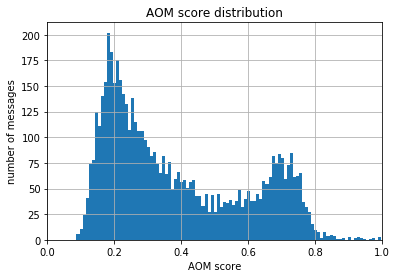

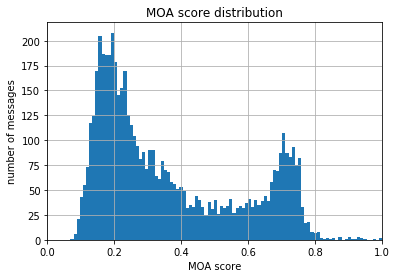

In [50]:
import matplotlib.pyplot as plt
df['aom_score'] = score_by_aom
df['moa_score'] = score_by_moa
df['aommoa_score'] = np.mean([score_by_aom, score_by_moa], axis=0)

df['max_score'] = score_by_max
df['avg_score'] = score_by_avg      

    
for i in range(1, all_scores_norm.shape[1]+1):
    df['score_'+str(i)] = all_scores_norm[:, i-1]

df.hist(column = 'aom_score', bins = 100)[0][0].set_xlim((0,1))
plt.title ('AOM score distribution')
plt.xlabel ('AOM score')
plt.ylabel ('number of messages')
df.hist(column = 'moa_score', bins = 100)[0][0].set_xlim((0,1))
plt.title ('MOA score distribution')
plt.xlabel ('MOA score')
plt.ylabel ('number of messages')

In [51]:
if 'label' in df_raw.columns:
    from sklearn.metrics import roc_auc_score
    df['label']=df_raw['label']
    cnt = sum(df['label'] == 1) 
    print(f'true number of outliers = {cnt}')
else:
    cnt = 100
pd.set_option('display.max_rows', cnt)

df.sort_values('aom_score', ascending=False)[0:cnt]

true number of outliers = 747


,1,aom_score,moa_score,aommoa_score,max_score,avg_score,score_1,score_2,score_3,score_4,...,score_7,score_8,score_9,score_10,score_11,score_12,score_13,score_14,score_15,label
4318,HIYA STU WOT U UP 2.IM IN SO MUCH TRUBLE AT HO...,0.997640,1.000000,0.998820,1.000000,0.956244,0.983306,0.983306,0.975991,0.892417,...,1.000000,0.967491,0.873948,0.990561,0.941644,0.961265,1.000000,1.000000,1.000000,False
4911,WE REGRET TO INFORM U THAT THE NHS HAS MADE A ...,0.994946,0.977461,0.986204,1.000000,0.946180,0.968091,0.968091,0.983653,0.965031,...,0.762829,0.969453,0.901922,1.000000,0.951906,0.950863,0.943814,0.932025,0.989892,False
2171,"""CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...",0.994186,1.000000,0.997093,1.000000,0.977994,1.000000,1.000000,1.000000,1.000000,...,0.785693,0.973074,1.000000,0.976745,1.000000,1.000000,0.981700,0.955552,0.997141,False
1407,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",0.976579,0.946921,0.961750,0.995546,0.916412,0.928995,0.928995,0.846447,0.941843,...,0.796398,0.995546,0.838259,0.967350,0.927309,0.947139,0.885898,0.876701,0.924460,True
1249,HI HUN! IM NOT COMIN 2NITE-TELL EVERY1 IM SORR...,0.975586,0.933116,0.954351,1.000000,0.923036,0.977000,0.977000,0.928646,0.903560,...,0.707323,1.000000,0.854520,0.938811,0.956868,0.946064,0.944721,0.956034,0.962671,False
3939,WHEN THE FIRST STRIKE IS A RED ONE. THE BIRD +...,0.965366,0.939387,0.952376,0.980133,0.911667,0.939990,0.939990,0.925981,0.917072,...,0.785952,0.792613,0.877304,0.969030,0.905714,0.980133,0.926722,0.912128,0.961702,False
1893,CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...,0.948853,0.941070,0.944962,0.967188,0.858165,0.893199,0.893199,0.837754,0.967188,...,0.646957,0.731472,0.769655,0.908655,0.895962,0.886459,0.834674,0.821385,0.861982,True
4206,IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...,0.934058,0.905521,0.919789,0.945406,0.857073,0.880379,0.880379,0.782093,0.890778,...,0.753376,0.807767,0.835150,0.901886,0.882381,0.865697,0.832243,0.811186,0.843838,True
1055,HIYA COMIN 2 BRISTOL 1 ST WEEK IN APRIL. LES G...,0.933935,0.909476,0.921705,0.948790,0.877312,0.904590,0.904590,0.841976,0.899873,...,0.753428,0.884103,0.726917,0.948790,0.892098,0.908922,0.892802,0.883924,0.919080,False
4994,"""HEY KATE, HOPE UR OK... WILL GIVE U A BUZ WED...",0.932628,0.874472,0.903550,0.960663,0.857176,0.886157,0.886157,0.817043,0.844351,...,0.758676,0.813220,0.730439,0.960663,0.846319,0.893065,0.871339,0.867228,0.904594,False


label 1 cnt = 747
label 0 cnt = 4827


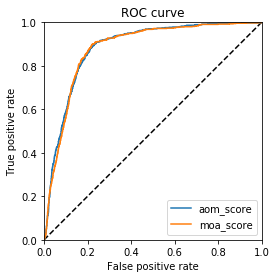

aom_score
370
roc_auc=0.8839304459048818
moa_score
357
roc_auc=0.8808856030433453
aommoa_score
360
roc_auc=0.8830371551810446
max_score
347
roc_auc=0.8798095496411447
avg_score
376
roc_auc=0.8879420728282926
score_1
390
roc_auc=0.8889604408934682
score_2
390
roc_auc=0.8889604408934682
score_3
354
roc_auc=0.8874572941306
score_4
365
roc_auc=0.8892879715810966
score_5
406
roc_auc=0.9116959516818743
score_6
412
roc_auc=0.9126474824094388
score_7
345
roc_auc=0.8550375800557386
score_8
369
roc_auc=0.8721945304871167
score_9
355
roc_auc=0.847790027591895
score_10
364
roc_auc=0.884615459282056
score_11
358
roc_auc=0.884192803255006
score_12
350
roc_auc=0.8818052404355354
score_13
312
roc_auc=0.8624568018639021
score_14
320
roc_auc=0.865164407370522
score_15
336
roc_auc=0.866630114130994


In [52]:
if 'label' in df_raw.columns:
    %matplotlib inline
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    from sklearn import metrics

    df['label']=df_raw['label']
    cnt = sum(df['label'] == 1) 
    print(f'label 1 cnt = {cnt}')
    print(f'label 0 cnt = {sum(df["label"] == 0)}')
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, _ = metrics.roc_curve(df.label, df['aom_score'])
    plt.plot(fpr, tpr, label='aom_score')
    fpr, tpr, _ = metrics.roc_curve(df.label, df['moa_score'])
    plt.plot(fpr, tpr, label='moa_score')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.show()

    for col in df.columns: 
        if 'score' in str(col):
            print(col)
            print(sum(df.sort_values(col, ascending=False)[0:cnt].label==1))
            print(f'roc_auc={roc_auc_score(df.label, df[col])}')


In [53]:
if 'First Name' in df_raw.columns:
    #df.sort_values('aom_score', ascending=False).to_csv('anomaly_score.csv')
    #df.sort_values('aom_score', ascending=False).to_excel('anomaly_score.xlsx', engine='xlsxwriter')
    #print(df[df['Address Line 1']=='Level One'].sort_values('moa_score', ascending=False))
    #print(df[df['Address Line 1'].str.startswith('Unit G')].sort_values('aom_score', ascending=False))
    #df.loc[(df['First Name']=='James') & (df['Last Name'] =='Stilllion'), :]
    #df.loc[(df['First Name'].str.len() == 1) | (df['First Name']=='Dr') | (df['First Name'] =='Mr.')].sort_values('aom_score', ascending=False)[0:250]  

    cl_inl = (df['First Name']=='John') & (df['Last Name'] =='Carter') & (df['Address Line 1']=='1 Queen Street')
    cl_outl = (df['First Name']=='Johhnn')


    inl_aom = df.loc[cl_inl, "aom_score"].values[0]
    outl_aom = df.loc[cl_outl, "aom_score"].values[0]
    print('aom scores', inl_aom, outl_aom)
    print('aom perc', sum(df.aom_score>inl_aom)/len(df), sum(df.aom_score>outl_aom)/len(df))

    inl_moa = df.loc[cl_inl, "moa_score"].values[0]
    outl_moa = df.loc[cl_outl, "moa_score"].values[0]

    print('moa scores',inl_moa, outl_moa)
    print('moa perc', sum(df.moa_score>inl_moa)/len(df), sum(df.moa_score>outl_moa)/len(df))

    display(df.loc[cl_inl|cl_outl, df.columns[7:]])
    
    cl = df.loc[cl_inl|cl_outl, df.columns[:5]]
    cl.index = ['normal', 'anomaly']
    display(cl)
    
    sc = pd.DataFrame(all_scores[cl_inl|cl_outl, :].round(4), columns = ['sc_' + str(x) for x in range(1,16)])
    sc.index = ['normal', 'anomaly']
    display(sc)
    
    norm = pd.DataFrame(all_scores_norm[cl_inl|cl_outl, :].round(4), columns = ['norm_' + str(x) for x in range(1,16)])
    norm.index = ['normal', 'anomaly']
    display(norm)
    
    aomoa = df.loc[cl_inl|cl_outl, df.columns[3:5]].round(4)
    aomoa.index = ['normal', 'anomaly']
    display(aomoa)
    
    
    df.hist(column = 'aom_score', bins = 100, density = True, color='lightblue')[0][0].set_xlim((0,1))
    plt.title ('AOM score distribution')
    plt.xlabel ('AOM score')
    plt.ylabel ('Density')
    plt.axvline(inl_aom, color='green', linestyle='dotted', linewidth=2, label = 'normal')
    plt.axvline(outl_aom, color='red', linestyle='dashed', linewidth=2, label = 'anomaly')
    plt.legend(loc='best')
    df.hist(column = 'moa_score', bins = 100, density = True, color='lightblue')[0][0].set_xlim((0,1))
    plt.title ('MOA score distribution')
    plt.xlabel ('MOA score')
    plt.ylabel ('Density')
    plt.axvline(inl_moa, color='green', linestyle='dotted', linewidth=2, label = 'normal')
    plt.axvline(outl_moa, color='red', linestyle='dashed', linewidth=2, label = 'anomaly')
    plt.legend(loc='best')
    